# Import Library

In [845]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Load Data

In [846]:
df = pd.read_excel("Updated_Data_Historis_2015_2025.xlsx", parse_dates=['Tanggal']) #parse = untuk ngubah kolom Tanggal jadi datetime
df = df.sort_values('Tanggal')
df = df.reset_index(drop=True)

In [847]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4020 entries, 0 to 4019
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Tanggal                             4020 non-null   datetime64[ns]
 1   Temperatur Minimum                  4020 non-null   object        
 2   Temperatur Maksimum                 4020 non-null   object        
 3   Temperatur Rata-rata                4020 non-null   object        
 4   Kelembapan Rata-rata                4020 non-null   object        
 5   Curah Hujan (mm)                    4020 non-null   object        
 6   Lamanya Penyinaran Matahari         4020 non-null   object        
 7   Kecepatan Angin Maksimum            4020 non-null   int64         
 8   Arah Angin Saat Kecepatan Maksimum  4020 non-null   int64         
 9   Kecepatan Angin Rata-rata           4020 non-null   int64         
 10  Arah Angin Terbanyak (°)

# Data Preparation

In [848]:
checkstripvalue = (df['Curah Hujan (mm)'] == "-").sum()
print(checkstripvalue)

497


In [849]:
df['Curah Hujan (mm)'] = df['Curah Hujan (mm)'].replace('-',0)

df['Curah Hujan (mm)'] = df['Curah Hujan (mm)'].astype(float)

C:\Users\Ayu Sekar\AppData\Local\Temp\ipykernel_13792\2154469297.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Curah Hujan (mm)'] = df['Curah Hujan (mm)'].replace('-',0)


In [850]:
checkstripvalue2 = (df['Curah Hujan (mm)'] == 8888).sum()
print(checkstripvalue2)

209


In [851]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor

df2 = pd.read_excel(
    "Updated_Data_Historis_2015_2025.xlsx",
    parse_dates=["Tanggal"]
)
df2 = df2.sort_values("Tanggal").reset_index(drop=True)

invalid_values = ["-", " - ", "–", "—", "N/A", "n/a", "", " ", "8888", 8888]
df2 = df2.replace(invalid_values, np.nan)

# Tangkap SEMUA blank aneh dari Excel
df2 = df2.replace(r'^\s*$', np.nan, regex=True)

col = "Arah Angin Terbanyak (°)"

df2[col] = (
    df2[col].astype(str)
            .str.strip()
            .str.upper()
            .str.replace("–", "-", regex=False)
            .str.replace("—", "-", regex=False)
)

mapping = {
    "C": 0, "N": 0, "NE": 45, "E": 90, "SE": 135,
    "S": 180, "SW": 225, "W": 270, "NW": 315
}

df2[col] = df2[col].map(mapping)


C:\Users\Ayu Sekar\AppData\Local\Temp\ipykernel_13792\4093600459.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df2 = df2.replace(invalid_values, np.nan)


# Fill Missing Values using RF Imputer for 8888 Values

In [852]:
for c in df2.columns:
    if c != "Tanggal":
        df2[c] = pd.to_numeric(df2[c], errors="coerce")

target = "Curah Hujan (mm)"

feature_cols = [
    c for c in df2.columns
    if c not in ["Tanggal", target]
]
df2[feature_cols] = df2[feature_cols].fillna(
    df2[feature_cols].median()
)


train_df = df2[df2[target].notna()]
pred_df  = df2[df2[target].isna()]

X_train = train_df[feature_cols]
y_train = train_df[target]

X_pred = pred_df[feature_cols]

rf = RandomForestRegressor(
    n_estimators=500,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

df2.loc[df2[target].isna(), target] = rf.predict(X_pred)

df2.to_excel("Ready_To_Use_Updated_RF.xlsx", index=False)
print("File disimpan: Ready_To_Use_Updated_RF.xlsx")

File disimpan: Ready_To_Use_Updated_RF.xlsx


In [853]:
data1= pd.read_excel('Ready_To_Use_Updated_RF.xlsx')

In [854]:
data1.isna().sum().sort_values(ascending=False)


Tanggal                               0
Temperatur Minimum                    0
Temperatur Maksimum                   0
Temperatur Rata-rata                  0
Kelembapan Rata-rata                  0
Curah Hujan (mm)                      0
Lamanya Penyinaran Matahari           0
Kecepatan Angin Maksimum              0
Arah Angin Saat Kecepatan Maksimum    0
Kecepatan Angin Rata-rata             0
Arah Angin Terbanyak (°)              0
dtype: int64

# Feature Engineering

In [855]:
#Check Correlation

df3 = pd.read_excel("Ready_To_Use_Updated_RF.xlsx")

numeric_df = df3.select_dtypes(include=[np.number])

target_corr = numeric_df.corr()['Curah Hujan (mm)'].abs().sort_values(ascending=False)

print(target_corr)


Curah Hujan (mm)                      1.000000
Kelembapan Rata-rata                  0.398399
Temperatur Minimum                    0.396346
Temperatur Rata-rata                  0.388622
Temperatur Maksimum                   0.320229
Lamanya Penyinaran Matahari           0.193858
Arah Angin Saat Kecepatan Maksimum    0.083090
Kecepatan Angin Rata-rata             0.025699
Arah Angin Terbanyak (°)              0.013451
Kecepatan Angin Maksimum              0.007921
Name: Curah Hujan (mm), dtype: float64


In [856]:
# Sort Date
df3['Tanggal'] = pd.to_datetime(df3['Tanggal'])
df3 = df3.sort_values('Tanggal').reset_index(drop=True)

df3['Curah Hujan Old'] = df3['Curah Hujan (mm)'].copy()

lags = [1, 2, 3, 4]

Features = [
    "Curah Hujan (mm)",
    "Kelembapan Rata-rata",
    "Temperatur Rata-rata",
    "Temperatur Maksimum",
    "Temperatur Minimum",
    "Lamanya Penyinaran Matahari"
]

# STEP 1: Buat lag features dulu
for col in Features:
    for lag in lags:
        df3[f"{col}_lag_{lag}"] = df3[col].shift(lag)

#Buat rolling mean untuk features
windows = [3, 7]


roll_features = {
    "Curah Hujan (mm)": "Rain",
    "Kelembapan Rata-rata": "Humidity",
    "Temperatur Rata-rata": "Temp_Avg",
    "Temperatur Maksimum": "Temp_Max",
    "Temperatur Minimum": "Temp_Min",
    "Lamanya Penyinaran Matahari": "Sunshine"
}


for col, prefix in roll_features.items():
    for w in windows:
        df3[f"{prefix}_roll_{w}"] = (
            df3[col]
            .shift(1)
            .rolling(window=w)
            .mean()
        )


# Buat EWM untuk curah hujan
df3['Rain_ewm_3'] = df3['Curah Hujan (mm)'].shift(1).ewm(span=3).mean()
df3['Rain_ewm_7'] = df3['Curah Hujan (mm)'].shift(1).ewm(span=7).mean()

# Buat rolling std 
df3['Rain_roll_std_7'] = df3['Curah Hujan (mm)'].shift(1).rolling(7).std()
# df3['Humid_roll_std_7'] = df3['Kelembapan Rata-rata'].shift(1).where(df3['Curah Hujan (mm)'] > 0).rolling(7).std()

# Cyclical Encoding 
df3["month"] = df3["Tanggal"].dt.month
df3["dayofyear"] = df3["Tanggal"].dt.dayofyear

df3["sin_doy"] = np.sin(2 * np.pi * df3["dayofyear"] / 365)
df3["cos_doy"] = np.cos(2 * np.pi * df3["dayofyear"] / 365)

# df3["Rain_3day_sum"] = df3["Curah Hujan (mm)"].shift(1).rolling(3).sum()
# df3["Rain_7day_sum"] = df3["Curah Hujan (mm)"].shift(1).rolling(7).sum()
q90 = df3["Curah Hujan (mm)"].quantile(0.9)

df3["HeavyRain_3d"] = (
    df3["Curah Hujan (mm)"].shift(1).rolling(3).max() > q90
).astype(int)

df3 = df3.iloc[max(lags + windows):].reset_index(drop=True)

df3 = df3.dropna()


df3.to_excel("df3_feature_engineered_lag137_fixed.xlsx", index=False)

In [857]:
print(f"Jumlah baris sebelum: {len(df3)}")
df3_clean = df3.dropna().reset_index(drop=True)
print(f"Jumlah baris sesudah: {len(df3_clean)}")
print(f"Baris yang dihapus: {len(df3) - len(df3_clean)}")


Jumlah baris sebelum: 4013
Jumlah baris sesudah: 4013
Baris yang dihapus: 0


In [858]:
df4 = pd.read_excel('df3_feature_engineered_lag137_fixed.xlsx')

In [859]:
#Check Correlation After Feature Engineering
numeric_df2 = df4.select_dtypes(include=[np.number])

target_corr = numeric_df2.corr()['Curah Hujan Old'].sort_values(ascending=False)

print(target_corr)

Curah Hujan (mm)                      1.000000
Curah Hujan Old                       1.000000
Kelembapan Rata-rata                  0.397834
Kelembapan Rata-rata_lag_1            0.366699
Humidity_roll_3                       0.298581
Humidity_roll_7                       0.263789
Rain_ewm_7                            0.237430
Rain_ewm_3                            0.220119
Kelembapan Rata-rata_lag_2            0.215912
Rain_roll_7                           0.207760
Rain_roll_3                           0.202300
Kelembapan Rata-rata_lag_3            0.191844
Curah Hujan (mm)_lag_1                0.179794
Kelembapan Rata-rata_lag_4            0.178857
cos_doy                               0.175952
Rain_roll_std_7                       0.167932
sin_doy                               0.142736
HeavyRain_3d                          0.134347
Curah Hujan (mm)_lag_2                0.131286
Curah Hujan (mm)_lag_3                0.092645
Arah Angin Saat Kecepatan Maksimum    0.082950
Curah Hujan (

In [860]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4013 entries, 0 to 4012
Data columns (total 56 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Tanggal                             4013 non-null   datetime64[ns]
 1   Temperatur Minimum                  4013 non-null   float64       
 2   Temperatur Maksimum                 4013 non-null   float64       
 3   Temperatur Rata-rata                4013 non-null   float64       
 4   Kelembapan Rata-rata                4013 non-null   int64         
 5   Curah Hujan (mm)                    4013 non-null   float64       
 6   Lamanya Penyinaran Matahari         4013 non-null   float64       
 7   Kecepatan Angin Maksimum            4013 non-null   int64         
 8   Arah Angin Saat Kecepatan Maksimum  4013 non-null   int64         
 9   Kecepatan Angin Rata-rata           4013 non-null   int64         
 10  Arah Angin Terbanyak (°)

# Data Split

In [861]:
df4 = df4.sort_values("Tanggal").reset_index(drop=True)
df4["Rain_Event_t+1"] = (
    df4["Curah Hujan Old"].shift(-1) > 0
).astype(int)
TARGET = "Rain_Event_t+1"

Column_to_drop = [
 "Tanggal",
 "Temperatur Minimum",  
 "Temperatur Maksimum",     
 "Temperatur Rata-rata",     
 "Kelembapan Rata-rata",
 "Curah Hujan Old",
 "Curah Hujan (mm)",
 "Lamanya Penyinaran Matahari",
 "Kecepatan Angin Maksimum",        
 "Arah Angin Saat Kecepatan Maksimum", 
 "Kecepatan Angin Rata-rata",     
 "Arah Angin Terbanyak (°)", 
 "Rain_Event_t+1"
]

X = df4.drop(columns=Column_to_drop, errors="ignore")
y = df4[TARGET]

In [862]:
split_ratio = 0.8
split_idx = int(len(X) * split_ratio)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]


In [863]:

# Cek distribusi target Anda
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

Rain_Event_t+1
1    0.553894
0    0.446106
Name: proportion, dtype: float64
Rain_Event_t+1
1    0.536737
0    0.463263
Name: proportion, dtype: float64


# Data Modelling 

## Classification

In [864]:
print("Train Rain_Event distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest Rain_Event distribution:")
print(y_test.value_counts(normalize=True))

print("\nPredicted distribution:")
print(pd.Series(y_pred_cls).value_counts(normalize=True))


Train Rain_Event distribution:
Rain_Event_t+1
1    0.553894
0    0.446106
Name: proportion, dtype: float64

Test Rain_Event distribution:
Rain_Event_t+1
1    0.536737
0    0.463263
Name: proportion, dtype: float64

Predicted distribution:
1    0.616438
0    0.383562
Name: proportion, dtype: float64


In [865]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor


clf = RandomForestClassifier(
    n_estimators=400,
    max_depth=4,
    min_samples_leaf=20,
    max_features="sqrt",
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)


clf.fit(X_train, y_train)

proba = clf.predict_proba(X_test)

if proba.shape[1] == 2:
    y_pred_prob = proba[:, 1]
else:
    y_pred_prob = np.zeros(len(X_test))

rain_threshold = 0.5
y_pred_cls = (y_pred_prob >= rain_threshold).astype(int)

print(
    "Stage 1 — Rain Event Accuracy:",
    accuracy_score(y_test, y_pred_cls)
)


Stage 1 — Rain Event Accuracy: 0.6214196762141968


In [866]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

print(classification_report(y_test, y_pred_cls))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_cls))
print(f"\nF1-Score: {f1_score(y_test, y_pred_cls):.4f}")

              precision    recall  f1-score   support

           0       0.61      0.51      0.55       372
           1       0.63      0.72      0.67       431

    accuracy                           0.62       803
   macro avg       0.62      0.61      0.61       803
weighted avg       0.62      0.62      0.62       803


Confusion Matrix:
[[188 184]
 [120 311]]

F1-Score: 0.6717


In [867]:
# Naive baseline: "Hujan besok = Hujan hari ini"
baseline_pred = (df4["Curah Hujan Old"] > 0).astype(int).shift(1)
baseline_acc = accuracy_score(
    y_test, 
    baseline_pred.iloc[split_idx:].dropna()
)
print(f"Baseline Accuracy: {baseline_acc:.2%}")

Baseline Accuracy: 58.28%



Top 10 Most Important Features:
                   feature  importance
37              Rain_ewm_7    0.124702
38         Rain_roll_std_7    0.094809
25             Rain_roll_7    0.091867
36              Rain_ewm_3    0.079705
24             Rain_roll_3    0.073626
2   Curah Hujan (mm)_lag_3    0.061551
40               dayofyear    0.056216
27         Humidity_roll_7    0.047959
39                   month    0.045056
3   Curah Hujan (mm)_lag_4    0.040819


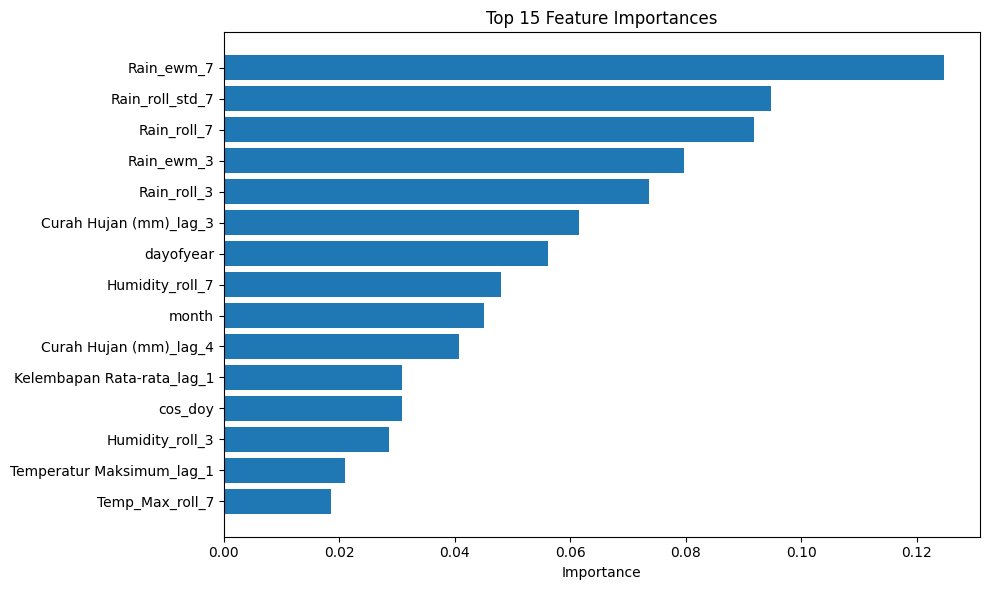

In [868]:
import matplotlib.pyplot as plt

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': clf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance.head(15)['feature'], 
         feature_importance.head(15)['importance'])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

[[188 184]
 [120 311]]


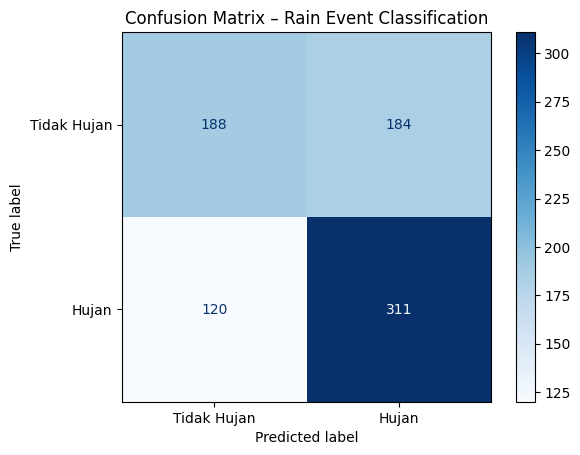

In [869]:
#Confusion Matrix 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_cls)
print(cm)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Tidak Hujan", "Hujan"]
)

disp.plot(cmap="Blues")
plt.title("Confusion Matrix – Rain Event Classification")
plt.show()


In [870]:
from sklearn.metrics import accuracy_score

y_train_pred = clf.predict(X_train)
y_test_pred  = clf.predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy :", accuracy_score(y_test, y_test_pred))


Train Accuracy: 0.7199376947040499
Test Accuracy : 0.6214196762141968


In [871]:
from sklearn.metrics import classification_report

print(classification_report(
    y_test,
    y_test_pred,
    target_names=["Tidak Hujan", "Hujan"]
))


              precision    recall  f1-score   support

 Tidak Hujan       0.61      0.51      0.55       372
       Hujan       0.63      0.72      0.67       431

    accuracy                           0.62       803
   macro avg       0.62      0.61      0.61       803
weighted avg       0.62      0.62      0.62       803



## Regression

In [872]:
# Setelah bagian klasifikasi
print("Kolom yang tersisa di df4:")
print(df4.columns.tolist())

# Cek apakah 'Curah Hujan Old' masih ada
if 'Curah Hujan Old' in df4.columns:
    print("✅ 'Curah Hujan Old' masih ada")
else:
    print("❌ 'Curah Hujan Old' TIDAK ADA - INI MASALAH!")

Kolom yang tersisa di df4:
['Tanggal', 'Temperatur Minimum', 'Temperatur Maksimum', 'Temperatur Rata-rata', 'Kelembapan Rata-rata', 'Curah Hujan (mm)', 'Lamanya Penyinaran Matahari', 'Kecepatan Angin Maksimum', 'Arah Angin Saat Kecepatan Maksimum', 'Kecepatan Angin Rata-rata', 'Arah Angin Terbanyak (°)', 'Curah Hujan Old', 'Curah Hujan (mm)_lag_1', 'Curah Hujan (mm)_lag_2', 'Curah Hujan (mm)_lag_3', 'Curah Hujan (mm)_lag_4', 'Kelembapan Rata-rata_lag_1', 'Kelembapan Rata-rata_lag_2', 'Kelembapan Rata-rata_lag_3', 'Kelembapan Rata-rata_lag_4', 'Temperatur Rata-rata_lag_1', 'Temperatur Rata-rata_lag_2', 'Temperatur Rata-rata_lag_3', 'Temperatur Rata-rata_lag_4', 'Temperatur Maksimum_lag_1', 'Temperatur Maksimum_lag_2', 'Temperatur Maksimum_lag_3', 'Temperatur Maksimum_lag_4', 'Temperatur Minimum_lag_1', 'Temperatur Minimum_lag_2', 'Temperatur Minimum_lag_3', 'Temperatur Minimum_lag_4', 'Lamanya Penyinaran Matahari_lag_1', 'Lamanya Penyinaran Matahari_lag_2', 'Lamanya Penyinaran Matahari_

MAE  : 6.804 mm
MSE  : 269.100 mm²
RMSE : 16.404 mm


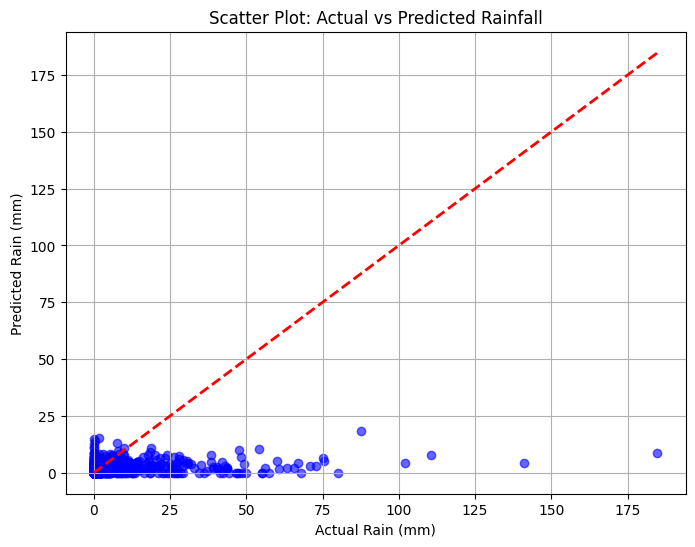

In [873]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

# =========================================
# 1️⃣ Buat dataset regresi (hanya untuk hari hujan)
# =========================================
df4["Rain_mm_t+1"] = df4["Curah Hujan Old"].shift(-1)

df4_rain = df4[(df4["Rain_Event_t+1"] == 1) & (df4["Rain_mm_t+1"] > 0)].copy()

# Filter berdasarkan curah hujan HARI INI (bukan besok

feature_cols = X_train.columns.tolist()  # pastikan X_train dari klasifikasi sudah ada

X_rain = df4_rain[feature_cols]
y_rain = np.log1p(df4_rain["Rain_mm_t+1"])

# =========================================
# 2️⃣ Split data untuk regresi
# =========================================
split_ratio2 = 0.8
split_idx_rain2 = int(len(X_rain) * split_ratio)

X_rain_train, X_rain_test = X_rain.iloc[:split_idx_rain2], X_rain.iloc[split_idx_rain2:]
y_rain_train, y_rain_test = y_rain.iloc[:split_idx_rain2], y_rain.iloc[split_idx_rain2:]

# =========================================
# 3️⃣ Latih model XGBRegressor
# =========================================
reg = XGBRegressor(
    n_estimators=800,
    max_depth=6,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=5,
    reg_alpha=0.5,
    reg_lambda=1.5,
    objective="reg:squarederror",
    random_state=42
)

reg.fit(X_rain_train, y_rain_train)

# =========================================
# 4️⃣ Prediksi pada test set klasifikasi
# =========================================
X_test_reg = df4.loc[X_test.index, feature_cols]  # X_test dari klasifikasi

final_pred = []

for i, idx in enumerate(X_test.index):
    prob = y_pred_prob[i]  # probabilitas hujan dari model klasifikasi

    if prob < rain_threshold:
        final_pred.append(0.0)
    else:
        rain_log = reg.predict(X_test_reg.loc[[idx]])[0]
        rain_mm  = np.expm1(rain_log)
        final_pred.append(prob * rain_mm)

final_pred = np.array(final_pred)

# =========================================
# 5️⃣ Hitung metrik evaluasi
# =========================================
y_true = df4.loc[X_test.index, "Rain_mm_t+1"]
mask = ~y_true.isna()

mae  = mean_absolute_error(y_true[mask], final_pred[mask])
rmse = np.sqrt(mean_squared_error(y_true[mask], final_pred[mask]))
mse  = mean_squared_error(y_true[mask], final_pred[mask])

print(f"MAE  : {mae:.3f} mm")
print(f"MSE  : {mse:.3f} mm²")
print(f"RMSE : {rmse:.3f} mm")

# =========================================
# 6️⃣ Plot scatter actual vs predicted
# =========================================
plt.figure(figsize=(8,6))
plt.scatter(y_true[mask], final_pred[mask], alpha=0.6, color="blue")
plt.plot([0, max(y_true[mask].max(), final_pred[mask].max())],
         [0, max(y_true[mask].max(), final_pred[mask].max())],
         color="red", linestyle="--", linewidth=2)
plt.xlabel("Actual Rain (mm)")
plt.ylabel("Predicted Rain (mm)")
plt.title("Scatter Plot: Actual vs Predicted Rainfall")
plt.grid(True)
plt.show()


In [874]:
# Cek ini dulu!
print("Distribusi Curah Hujan:")
print(df4[df4["Curah Hujan Old"] > 0]["Curah Hujan Old"].describe())

# Cek proporsi hujan ekstrem
q90 = df4["Curah Hujan Old"].quantile(0.9)
print(f"\n90th percentile: {q90:.2f} mm")
print(f"Max rainfall: {df4['Curah Hujan Old'].max():.2f} mm")

Distribusi Curah Hujan:
count    2209.000000
mean       12.267589
std        20.881635
min         0.001000
25%         1.338600
50%         5.000000
75%        14.400000
max       277.500000
Name: Curah Hujan Old, dtype: float64

90th percentile: 19.48 mm
Max rainfall: 277.50 mm


In [875]:
# =========================================
# 1️⃣ Buat Rain_mm_t+1
# =========================================
df4["Rain_mm_t+1"] = df4["Curah Hujan Old"].shift(-1)

# =========================================
# 2️⃣ Filter HANYA data hujan
# =========================================
df4_rain = df4[
    (df4["Rain_Event_t+1"] == 1) &
    (df4["Rain_mm_t+1"] > 0)
].copy()

feature_cols = X_train.columns.tolist()

# =========================================
# 3️⃣ Split regresi BERDASARKAN TIME, BUKAN INDEX
# =========================================
# Gunakan split yang SAMA dengan klasifikasi
split_date = df4.iloc[split_idx]['Tanggal']  # tanggal split dari klasifikasi

df4_rain_train = df4_rain[df4_rain['Tanggal'] < split_date]
df4_rain_test  = df4_rain[df4_rain['Tanggal'] >= split_date]

X_rain_train = df4_rain_train[feature_cols]
y_rain_train = np.log1p(df4_rain_train["Rain_mm_t+1"])

X_rain_test = df4_rain_test[feature_cols]
y_rain_test = np.log1p(df4_rain_test["Rain_mm_t+1"])

# print(f"✓ Train period: {df4_rain_train['Tanggal'].min()} to {df4_rain_train['Tanggal'].max()}")
# print(f"✓ Test period : {df4_rain_test['Tanggal'].min()} to {df4_rain_test['Tanggal'].max()}")
# print(f"✓ Train samples: {len(X_rain_train)}")
# print(f"✓ Test samples : {len(X_rain_test)}")

# =========================================
# 4️⃣ Training dengan data TRAIN ONLY
# =========================================
reg = XGBRegressor(
    n_estimators=800,
    max_depth=6,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=5,
    reg_alpha=0.5,
    reg_lambda=1.5,
    objective="reg:squarederror",
    random_state=42
)

# ✅ FIT PAKAI TRAIN DATA ONLY!
reg.fit(X_rain_train, y_rain_train)

# =========================================
# 5️⃣ Evaluasi pada X_rain_test (opsional)
# =========================================
y_rain_pred = reg.predict(X_rain_test)
mae_rain = mean_absolute_error(y_rain_test, y_rain_pred)
rmse_rain = np.sqrt(mean_squared_error(y_rain_test, y_rain_pred))

print(f"\n📊 Regression Model Performance (on rainy days only):")
print(f"MAE  : {mae_rain:.3f} (log scale)")
print(f"RMSE : {rmse_rain:.3f} (log scale)")

# Convert back to mm
y_rain_pred_mm = np.expm1(y_rain_pred)
y_rain_test_mm = np.expm1(y_rain_test)
mae_rain_mm = mean_absolute_error(y_rain_test_mm, y_rain_pred_mm)
print(f"MAE  : {mae_rain_mm:.3f} mm (original scale)")

# =========================================
# 6️⃣ Prediksi Final (Two-Stage)
# =========================================
X_test_reg = df4.loc[X_test.index, feature_cols]

final_pred = []

for i, idx in enumerate(X_test.index):
    prob = y_pred_prob[i]

    if prob < rain_threshold:
        final_pred.append(0.0)
    else:
        rain_log = reg.predict(X_test_reg.loc[[idx]])[0]
        rain_mm  = np.expm1(rain_log)
        final_pred.append(prob * rain_mm)

final_pred = np.array(final_pred)

# =========================================
# 7️⃣ Evaluasi Final
# =========================================
y_true = df4.loc[X_test.index, "Rain_mm_t+1"]
mask = ~y_true.isna()

mae  = mean_absolute_error(y_true[mask], final_pred[mask])
rmse = np.sqrt(mean_squared_error(y_true[mask], final_pred[mask]))

print(f"\n🎯 Final Two-Stage Model Performance:")
print(f"MAE  : {mae:.3f} mm")
print(f"RMSE : {rmse:.3f} mm")


📊 Regression Model Performance (on rainy days only):
MAE  : 1.044 (log scale)
RMSE : 1.252 (log scale)
MAE  : 11.264 mm (original scale)

🎯 Final Two-Stage Model Performance:
MAE  : 6.819 mm
RMSE : 16.423 mm


In [876]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
import lightgbm as lgb

# List model
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(
        n_estimators=500, max_depth=6, random_state=42
    ),
    "GradientBoosting": GradientBoostingRegressor(
        n_estimators=500, max_depth=6, learning_rate=0.05, random_state=42
    ),
    "XGBoost": XGBRegressor(
        n_estimators=800, max_depth=6, learning_rate=0.03,
        subsample=0.8, colsample_bytree=0.8, min_child_weight=5,
        reg_alpha=0.5, reg_lambda=1.5, objective="reg:squarederror", random_state=42
    ),
    "LightGBM": lgb.LGBMRegressor(
        n_estimators=800, max_depth=6, learning_rate=0.03,
        subsample=0.8, colsample_bytree=0.8, random_state=42
    )
}

results = []

for name, model in models.items():
    # Fit model
    model.fit(X_rain_train, y_rain_train)
    
    # Predict
    y_pred_log = model.predict(X_rain_test)
    y_pred_mm  = np.expm1(y_pred_log)
    y_true_mm  = np.expm1(y_rain_test)
    
    # Metrics
    mae_log  = mean_absolute_error(y_rain_test, y_pred_log)
    rmse_log = np.sqrt(mean_squared_error(y_rain_test, y_pred_log))
    mae_mm   = mean_absolute_error(y_true_mm, y_pred_mm)
    rmse_mm  = np.sqrt(mean_squared_error(y_true_mm, y_pred_mm))
    
    results.append({
        "Model": name,
        "MAE_log": mae_log,
        "RMSE_log": rmse_log,
        "MAE_mm": mae_mm,
        "RMSE_mm": rmse_mm
    })

# Convert results ke DataFrame dan tampilkan
import pandas as pd
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("RMSE_mm")
print(results_df)


              Model   MAE_log  RMSE_log     MAE_mm    RMSE_mm
3           XGBoost  1.044020  1.252109  11.264283  21.186588
4          LightGBM  1.045594  1.255054  11.311910  21.264014
1      RandomForest  1.009272  1.201438  10.978987  21.378545
2  GradientBoosting  1.079806  1.288141  11.548115  21.379746
0  LinearRegression  1.003319  1.207944  10.955717  21.389409
